# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Finding Lane Lines** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/ricardo-0x07/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/571/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Camera Calibration

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [91]:
## camera calibration 
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

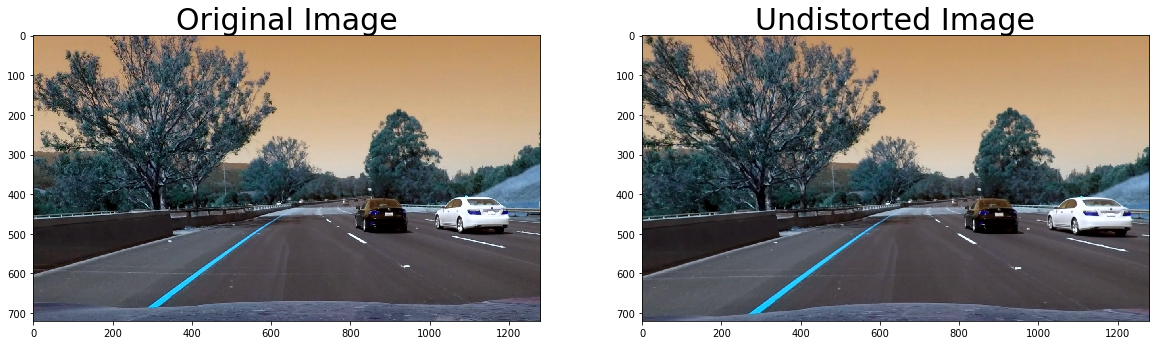

In [92]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('test_images/test6.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('test_images/test6_undst.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [90]:
def perspective_transform(img, nx, ny, mtx, dist, warp=True, height_pct=.62, bias=.25,bottom_trim=.70):
    gray = img
    img_size = (gray.shape[1], gray.shape[0])

    # For source points I'm grabbing the outer four detected corners
    bottom_width = .76
    middle_width = .08
    w,h = 1280,720
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
    dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])
    # Given src and dst points, calculate the perspective transform matrix
    if(warp):
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(gray, M, img_size)

    return warped, M


True

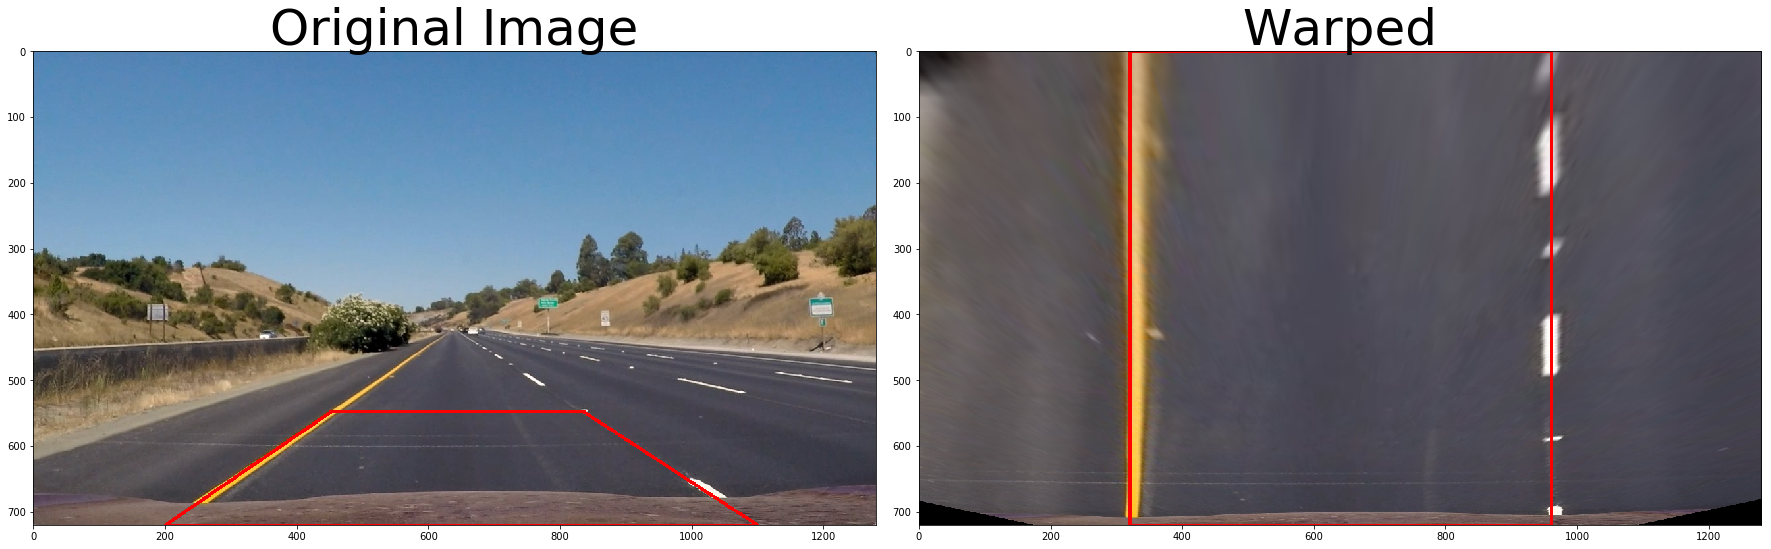

In [97]:
# ## Perspective Transform
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = mpimg.imread('test_images/straight_lines1.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

gray = img
# Grab the image shape
img_size = (gray.shape[1], gray.shape[0])

# For source points I'm grabbing the outer four detected corners
bottom_width = .76
middle_width = .08
w,h = 1280,720
x,y = 0.5*w, 0.8*h
src = np.float32([[200./1280*w,720./720*h],
              [453./1280*w,547./720*h],
              [835./1280*w,547./720*h],
              [1100./1280*w,720./720*h]])
dst = np.float32([[(w-x)/2.,h],
              [(w-x)/2.,0.82*h],
              [(w+x)/2.,0.82*h],
              [(w+x)/2.,h]])
# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(gray, M, img_size)

src = np.array([[200./1280*w,720./720*h],
              [453./1280*w,547./720*h],
              [835./1280*w,547./720*h],
              [1100./1280*w,720./720*h]], np.int32)
src = src.reshape((-1,1,2))
dst = np.array([[(w-x)/2.,h],
              [(w-x)/2.,0],
              [(w+x)/2.,0],
              [(w+x)/2.,h]], np.int32)
dst = dst.reshape((-1,1,2))

cv2.polylines(img,[src],True,(255,0,0),4)
cv2.polylines(warped,[dst],True,(255,0,0),4)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
combined = np.concatenate((img,warped), axis=1)
cv2.imwrite('output_images/warped_straight_lines.jpg', combined)

## Process Binary Images

In [65]:
image = mpimg.imread('test_images/test5.jpg')

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return dir_binary


# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
ksize = 9
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

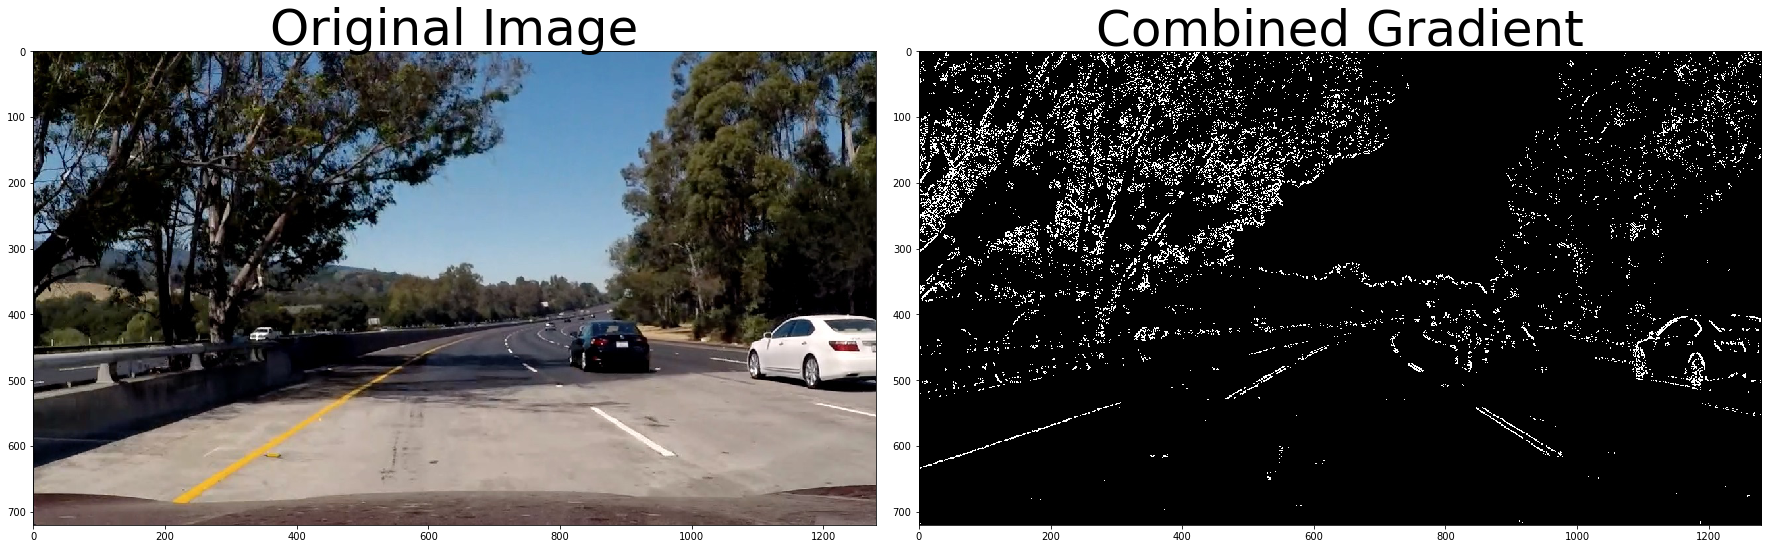

In [49]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) ] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
cv2.imwrite('output_images/binary_image.jpg', combined)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [98]:

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def color_threshold(image, R_thresh = (0, 100), G_thresh = (0, 100), L_thresh=(35, 255), S_thresh=(15, 255), V_thresh=(15, 255)):
    R_channel = image[:,:,0]
    R_binary = np.zeros_like(R_channel)
    R_binary[(R_channel >= R_thresh[0]) & (R_channel <= R_thresh[1])] = 1

    G_channel = image[:,:,1]
    G_binary = np.zeros_like(G_channel)
    G_binary[(G_channel >= G_thresh[0]) & (G_channel <= G_thresh[1])] = 1

    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S_channel = hls[:,:,2]
    S_binary = np.zeros_like(S_channel)
    S_binary[(S_channel >= S_thresh[0]) & (S_channel <= S_thresh[1])] = 1

    L_channel = hls[:,:,1]
    L_binary = np.zeros_like(L_channel)
    L_binary[(L_channel >= L_thresh[0]) & (L_channel <= L_thresh[1])] = 1

    # 1) Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # 2) Apply a threshold to the V channel
    V_channel = hsv[:,:,2]
    V_binary = np.zeros_like(V_channel)
    V_binary[(V_binary >= V_thresh[0]) & (V_binary <= V_thresh[1])] = 1

    binary_output = np.zeros_like(S_channel)
    binary_output[(((S_binary == 1) | (V_binary == 1)) & (L_binary==1)) | ((R_binary==1) & (G_channel==1))] = 1
    # 3) Return a binary image of threshold result
    return binary_output
    

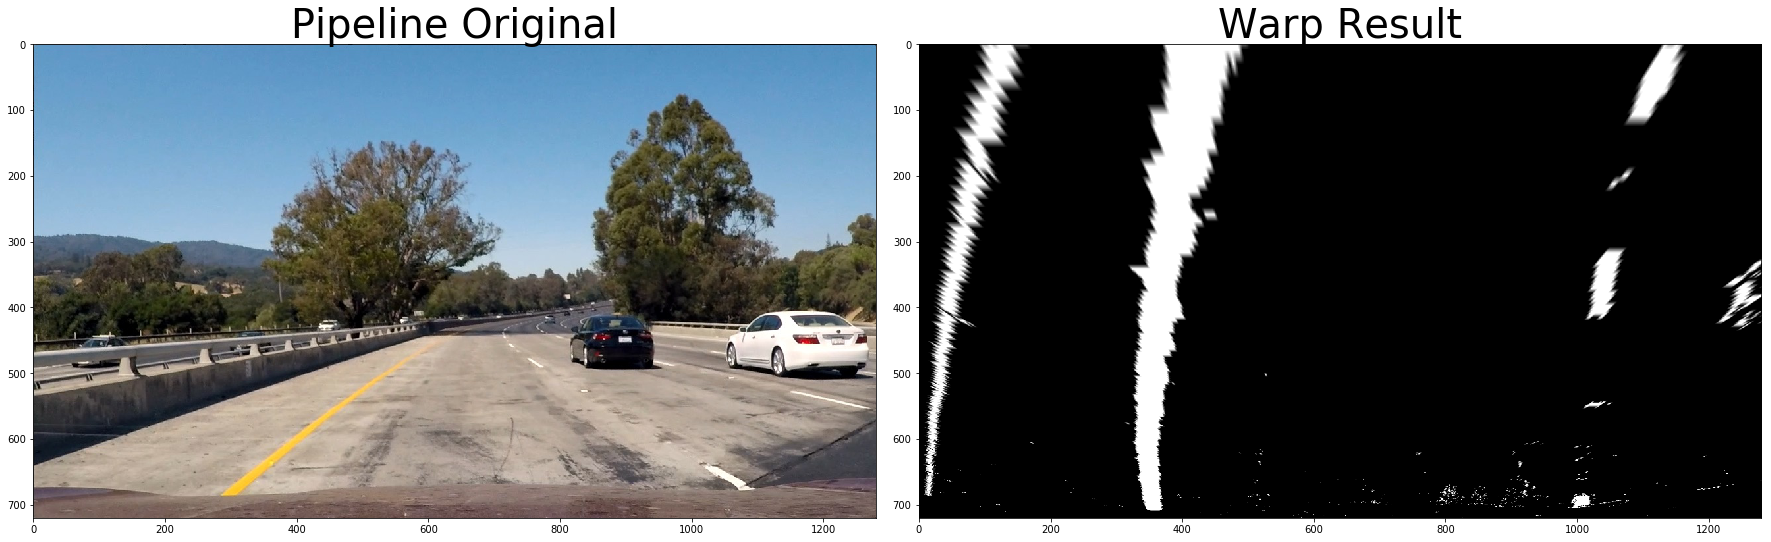

In [101]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Edit this function to create your own pipeline.
def warp(img, mtx, dist, nx, ny, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    ksize = 9
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Threshold x gradient
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 255))
    # Threshold y gradient
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 255))
    # Threshold color channel
    color_binary = color_threshold(img, S_thresh=(100, 255), V_thresh=(100, 255))
    # Combine the binary thresholds
    pre_process_image = np.zeros_like(img[:,:,0])
    pre_process_image[((gradx == 1) & (grady == 1)| color_binary == 1)] = 255
    
    
    result, perspective_M = perspective_transform(pre_process_image, nx, ny, mtx, dist, height_pct=.62, bias=.10,bottom_trim=.935)
    
    return result
    

image = mpimg.imread('test_images/test1.jpg')
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
binary_warped= warp(image,mtx, dist, nx, ny)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Pipeline Original', fontsize=40)
ax2.imshow(binary_warped, cmap='gray')
# cv2.imwrite('output_images/binary_warped.jpg', binary_warped)
ax2.set_title('Warp Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [102]:

def process_image(image):
    """
    """
    # Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    nx = 9 # the number of inside corners in x
    ny = 6 # the number of inside corners in y

    binary_warped= warp(image,mtx, dist, nx, ny)

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    print('histogram.shape',histogram.shape)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 650

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    road_warped, perspective_M = perspective_transform(result, nx, ny, mtx, dist, warp=False)
    result = cv2.addWeighted(image, 1, road_warped, 0.9, 0)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    y_eval = np.max(ploty)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

    # Calculate the offset of the car on the road
    camera_center = (left_fitx[-1]+right_fitx[-1])/2
    center_diff = (camera_center-binary_warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if(center_diff<=0):
        side_pos = 'right'
    # Draw the text showing curvature, offset, and speed
    cv2.putText(result, 'Radius of Curvature = '+str(round((left_curverad+right_curverad)/2,3))+'(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3)
    cv2.putText(result, 'Vehicle is '+str(round(center_diff,3))+'(m) '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3)
    return result

histogram.shape (1280,)
1076.40740344 m 608.574774038 m


(720, 0)

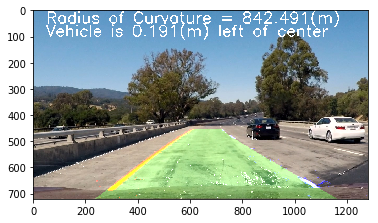

In [103]:
imagex = mpimg.imread('test_images/test1.jpg')
result = process_image(imagex)
cv2.imwrite('output_images/color_fit_lines.jpg', result)
plt.imshow(result)
plt.xlim(0, 1280)
plt.ylim(720, 0)


histogram.shape (1280,)
histogram.shape (1280,)
histogram.shape (1280,)
histogram.shape (1280,)
histogram.shape (1280,)
histogram.shape (1280,)
histogram.shape (1280,)
histogram.shape (1280,)
histogram.shape (1280,)


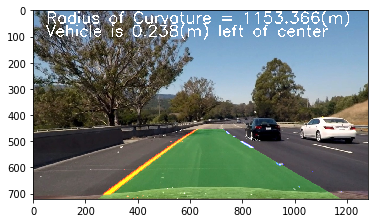

In [105]:
# imagex = mpimg.imread('test_images/test1.jpg')
# result = process_image(imagex)
# cv2.imwrite('output_images/test1.jpg', result)
# plt.imshow(result)
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

import os
from lane_line_tracker import Lane_Line_Tracker
tracker = Lane_Line_Tracker()
dirs = os.listdir("test_images/")
for image_name in dirs:
    imagex = mpimg.imread('test_images/'+ image_name)
    result = tracker.process_image(imagex)
    cv2.imwrite('test/'+ image_name, result)
    plt.imshow(result)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [1120]:
import os
dirs = os.listdir("test_images/")
print(dirs)

['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg', 'test6_undst.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

1287.33923905 m 693.458116328 m
1287.33923905 m 693.458116328 m
1287.33923905 m 693.458116328 m
1287.33923905 m 693.458116328 m
1287.33923905 m 693.458116328 m
1287.33923905 m 693.458116328 m
1287.33923905 m 693.458116328 m
1287.33923905 m 693.458116328 m
1287.33923905 m 693.458116328 m


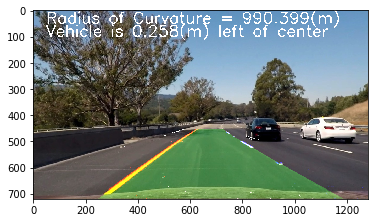

In [1185]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# Read in and grayscale the image
# plt.imshow(image)
# for file in dirs:
# print(file)
for image_name in dirs:
    imagex = mpimg.imread('test_images/'+ image_name)
    result = process_image(imagex)
    cv2.imwrite('output_images/'+ image_name, result)
    plt.imshow(result)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [35]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [106]:
white_output = 'test/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(tracker.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

histogram.shape (1280,)
[MoviePy] >>>> Building video test/project_video.mp4
[MoviePy] Writing video test/project_video.mp4


  0%|          | 1/1261 [00:00<06:15,  3.36it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  0%|          | 4/1261 [00:01<06:23,  3.28it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  0%|          | 5/1261 [00:01<05:17,  3.95it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  1%|          | 7/1261 [00:02<05:17,  3.95it/s]

histogram.shape (1280,)


  1%|          | 8/1261 [00:02<05:36,  3.72it/s]

histogram.shape (1280,)


  1%|          | 9/1261 [00:02<05:00,  4.16it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  1%|          | 11/1261 [00:03<04:46,  4.36it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  1%|          | 14/1261 [00:03<04:02,  5.15it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  1%|          | 15/1261 [00:03<04:16,  4.85it/s]

histogram.shape (1280,)


  1%|▏         | 16/1261 [00:03<04:04,  5.09it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  1%|▏         | 18/1261 [00:04<03:55,  5.28it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  2%|▏         | 21/1261 [00:04<03:44,  5.53it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  2%|▏         | 22/1261 [00:05<03:44,  5.52it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  2%|▏         | 25/1261 [00:05<03:31,  5.83it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  2%|▏         | 26/1261 [00:05<03:48,  5.42it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  2%|▏         | 28/1261 [00:06<03:48,  5.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  2%|▏         | 31/1261 [00:06<03:27,  5.94it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  3%|▎         | 32/1261 [00:06<03:23,  6.03it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  3%|▎         | 34/1261 [00:07<03:31,  5.80it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  3%|▎         | 36/1261 [00:07<03:47,  5.38it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  3%|▎         | 38/1261 [00:07<03:55,  5.20it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  3%|▎         | 41/1261 [00:08<03:28,  5.85it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  3%|▎         | 42/1261 [00:08<03:23,  5.98it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  3%|▎         | 44/1261 [00:08<03:29,  5.80it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  4%|▎         | 47/1261 [00:09<03:19,  6.08it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  4%|▍         | 48/1261 [00:09<03:27,  5.84it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  4%|▍         | 51/1261 [00:10<04:20,  4.65it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  4%|▍         | 53/1261 [00:10<03:48,  5.29it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  4%|▍         | 55/1261 [00:10<03:21,  5.98it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  4%|▍         | 56/1261 [00:11<03:50,  5.22it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  5%|▍         | 58/1261 [00:11<03:48,  5.27it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  5%|▍         | 61/1261 [00:12<03:29,  5.72it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  5%|▍         | 63/1261 [00:12<03:14,  6.15it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  5%|▌         | 64/1261 [00:12<03:11,  6.25it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  5%|▌         | 66/1261 [00:12<03:31,  5.64it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  5%|▌         | 68/1261 [00:13<03:43,  5.33it/s]

histogram.shape (1280,)


  5%|▌         | 69/1261 [00:13<03:47,  5.25it/s]

histogram.shape (1280,)


  6%|▌         | 70/1261 [00:13<03:55,  5.05it/s]

histogram.shape (1280,)


  6%|▌         | 71/1261 [00:13<04:03,  4.89it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  6%|▌         | 74/1261 [00:14<03:33,  5.57it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  6%|▌         | 75/1261 [00:14<03:36,  5.49it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  6%|▌         | 76/1261 [00:15<07:25,  2.66it/s]

histogram.shape (1280,)


  6%|▌         | 77/1261 [00:16<10:14,  1.93it/s]

histogram.shape (1280,)


  6%|▌         | 78/1261 [00:16<10:28,  1.88it/s]

histogram.shape (1280,)


  6%|▋         | 81/1261 [00:17<06:57,  2.83it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  7%|▋         | 82/1261 [00:18<06:05,  3.23it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  7%|▋         | 85/1261 [00:18<04:07,  4.76it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  7%|▋         | 86/1261 [00:18<04:16,  4.59it/s]

histogram.shape (1280,)


  7%|▋         | 87/1261 [00:19<04:41,  4.16it/s]

histogram.shape (1280,)


  7%|▋         | 89/1261 [00:19<03:54,  4.99it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  7%|▋         | 90/1261 [00:19<04:37,  4.23it/s]

histogram.shape (1280,)


  7%|▋         | 92/1261 [00:20<03:56,  4.95it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  7%|▋         | 93/1261 [00:20<03:40,  5.29it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  8%|▊         | 96/1261 [00:20<03:15,  5.95it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  8%|▊         | 97/1261 [00:20<03:18,  5.86it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  8%|▊         | 98/1261 [00:21<04:02,  4.80it/s]

histogram.shape (1280,)


  8%|▊         | 99/1261 [00:22<09:06,  2.12it/s]

histogram.shape (1280,)


  8%|▊         | 101/1261 [00:23<08:24,  2.30it/s]

histogram.shape (1280,)


  8%|▊         | 102/1261 [00:23<07:08,  2.70it/s]

histogram.shape (1280,)


  8%|▊         | 103/1261 [00:23<06:06,  3.16it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  8%|▊         | 104/1261 [00:24<11:55,  1.62it/s]

histogram.shape (1280,)


  8%|▊         | 106/1261 [00:26<13:46,  1.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  9%|▊         | 108/1261 [00:27<09:11,  2.09it/s]

histogram.shape (1280,)


  9%|▊         | 109/1261 [00:27<07:20,  2.62it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  9%|▉         | 112/1261 [00:28<05:43,  3.35it/s]

histogram.shape (1280,)
histogram.shape (1280,)
histogram.shape (1280,)


  9%|▉         | 113/1261 [00:28<06:07,  3.12it/s]

histogram.shape (1280,)


  9%|▉         | 114/1261 [00:29<07:16,  2.63it/s]

histogram.shape (1280,)


  9%|▉         | 116/1261 [00:31<14:02,  1.36it/s]

histogram.shape (1280,)
histogram.shape (1280,)


  9%|▉         | 118/1261 [00:32<09:03,  2.10it/s]

histogram.shape (1280,)


  9%|▉         | 119/1261 [00:32<07:31,  2.53it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 10%|▉         | 122/1261 [00:32<04:44,  4.01it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 10%|▉         | 123/1261 [00:33<04:14,  4.47it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 10%|▉         | 126/1261 [00:33<03:47,  4.99it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 10%|█         | 127/1261 [00:33<03:49,  4.94it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 10%|█         | 129/1261 [00:34<03:51,  4.89it/s]

histogram.shape (1280,)


 10%|█         | 130/1261 [00:34<03:52,  4.86it/s]

histogram.shape (1280,)


 10%|█         | 131/1261 [00:34<03:51,  4.87it/s]

histogram.shape (1280,)


 10%|█         | 132/1261 [00:34<03:53,  4.84it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 11%|█         | 134/1261 [00:35<03:45,  5.00it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 11%|█         | 136/1261 [00:35<03:38,  5.15it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 11%|█         | 138/1261 [00:36<03:35,  5.20it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 11%|█         | 141/1261 [00:36<03:13,  5.77it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 11%|█▏        | 143/1261 [00:36<03:01,  6.15it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 11%|█▏        | 144/1261 [00:37<03:03,  6.09it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 12%|█▏        | 146/1261 [00:37<03:08,  5.91it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 12%|█▏        | 149/1261 [00:37<02:56,  6.29it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 12%|█▏        | 151/1261 [00:38<02:50,  6.52it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 12%|█▏        | 153/1261 [00:38<02:53,  6.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 12%|█▏        | 155/1261 [00:38<02:55,  6.31it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 12%|█▏        | 157/1261 [00:39<02:49,  6.51it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 13%|█▎        | 159/1261 [00:39<02:51,  6.44it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 13%|█▎        | 161/1261 [00:39<02:47,  6.56it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 13%|█▎        | 163/1261 [00:40<02:51,  6.42it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 13%|█▎        | 165/1261 [00:40<02:51,  6.39it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 13%|█▎        | 167/1261 [00:40<02:48,  6.50it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 13%|█▎        | 169/1261 [00:41<02:50,  6.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 14%|█▎        | 171/1261 [00:41<02:46,  6.54it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 14%|█▎        | 173/1261 [00:41<02:48,  6.47it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 14%|█▍        | 175/1261 [00:41<02:51,  6.35it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 14%|█▍        | 177/1261 [00:42<02:43,  6.61it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 14%|█▍        | 179/1261 [00:42<02:40,  6.74it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 14%|█▍        | 181/1261 [00:42<02:42,  6.67it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 15%|█▍        | 183/1261 [00:43<02:41,  6.66it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 15%|█▍        | 185/1261 [00:43<02:44,  6.52it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 15%|█▍        | 186/1261 [00:43<02:47,  6.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 15%|█▍        | 189/1261 [00:44<02:47,  6.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 15%|█▌        | 190/1261 [00:44<02:46,  6.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 15%|█▌        | 192/1261 [00:44<03:06,  5.72it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 15%|█▌        | 194/1261 [00:45<03:15,  5.46it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 15%|█▌        | 195/1261 [00:47<15:12,  1.17it/s]

histogram.shape (1280,)


 16%|█▌        | 196/1261 [00:48<18:39,  1.05s/it]

histogram.shape (1280,)


 16%|█▌        | 199/1261 [00:49<08:38,  2.05it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 16%|█▌        | 200/1261 [00:49<06:55,  2.56it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 16%|█▌        | 201/1261 [00:50<06:19,  2.79it/s]

histogram.shape (1280,)


 16%|█▌        | 203/1261 [00:50<05:53,  2.99it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 16%|█▋        | 205/1261 [00:51<04:26,  3.97it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 16%|█▋        | 207/1261 [00:52<08:52,  1.98it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 17%|█▋        | 210/1261 [00:54<07:01,  2.49it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 17%|█▋        | 211/1261 [00:54<05:38,  3.10it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 17%|█▋        | 213/1261 [00:54<04:20,  4.02it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 17%|█▋        | 214/1261 [00:55<07:58,  2.19it/s]

histogram.shape (1280,)


 17%|█▋        | 217/1261 [00:56<05:04,  3.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)
histogram.shape (1280,)


 17%|█▋        | 218/1261 [00:56<06:28,  2.68it/s]

histogram.shape (1280,)


 17%|█▋        | 220/1261 [00:57<05:03,  3.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 18%|█▊        | 221/1261 [00:59<15:29,  1.12it/s]

histogram.shape (1280,)


 18%|█▊        | 222/1261 [01:00<12:46,  1.36it/s]

histogram.shape (1280,)


 18%|█▊        | 224/1261 [01:00<08:49,  1.96it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 18%|█▊        | 226/1261 [01:07<28:31,  1.65s/it]

histogram.shape (1280,)
histogram.shape (1280,)


 18%|█▊        | 228/1261 [01:07<15:48,  1.09it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 18%|█▊        | 229/1261 [01:08<15:00,  1.15it/s]

histogram.shape (1280,)


 18%|█▊        | 231/1261 [01:09<12:01,  1.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 18%|█▊        | 232/1261 [01:10<10:23,  1.65it/s]

histogram.shape (1280,)


 18%|█▊        | 233/1261 [01:10<08:53,  1.93it/s]

histogram.shape (1280,)


 19%|█▊        | 235/1261 [01:13<16:04,  1.06it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 19%|█▉        | 237/1261 [01:14<12:09,  1.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 19%|█▉        | 238/1261 [01:15<11:37,  1.47it/s]

histogram.shape (1280,)


 19%|█▉        | 239/1261 [01:16<12:45,  1.33it/s]

histogram.shape (1280,)


 19%|█▉        | 240/1261 [01:16<10:39,  1.60it/s]

histogram.shape (1280,)


 19%|█▉        | 243/1261 [01:17<06:12,  2.73it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 19%|█▉        | 245/1261 [01:17<04:27,  3.79it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 20%|█▉        | 247/1261 [01:17<03:27,  4.88it/s]

histogram.shape (1280,)
histogram.shape (1280,)
histogram.shape (1280,)


 20%|█▉        | 249/1261 [01:18<03:36,  4.67it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 20%|█▉        | 250/1261 [01:18<03:42,  4.55it/s]

histogram.shape (1280,)


 20%|█▉        | 251/1261 [01:18<04:22,  3.85it/s]

histogram.shape (1280,)


 20%|██        | 253/1261 [01:19<04:59,  3.37it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 20%|██        | 255/1261 [01:20<05:19,  3.15it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 20%|██        | 257/1261 [01:21<04:50,  3.46it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 20%|██        | 258/1261 [01:21<04:23,  3.81it/s]

histogram.shape (1280,)


 21%|██        | 259/1261 [01:21<05:31,  3.02it/s]

histogram.shape (1280,)


 21%|██        | 262/1261 [01:22<04:24,  3.78it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 21%|██        | 263/1261 [01:22<04:05,  4.07it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 21%|██        | 265/1261 [01:23<04:27,  3.72it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 21%|██▏       | 268/1261 [01:24<04:39,  3.56it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 21%|██▏       | 269/1261 [01:24<03:59,  4.14it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 22%|██▏       | 272/1261 [01:25<03:06,  5.30it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 22%|██▏       | 273/1261 [01:25<02:55,  5.64it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 22%|██▏       | 275/1261 [01:25<03:20,  4.93it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 22%|██▏       | 278/1261 [01:26<02:54,  5.64it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 22%|██▏       | 280/1261 [01:26<02:41,  6.08it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 22%|██▏       | 282/1261 [01:26<02:36,  6.24it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 22%|██▏       | 283/1261 [01:27<03:09,  5.16it/s]

histogram.shape (1280,)


 23%|██▎       | 285/1261 [01:27<02:49,  5.77it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 23%|██▎       | 286/1261 [01:27<02:53,  5.62it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 23%|██▎       | 289/1261 [01:28<02:33,  6.35it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 23%|██▎       | 291/1261 [01:28<02:29,  6.49it/s]

histogram.shape (1280,)
histogram.shape (1280,)
histogram.shape (1280,)


 23%|██▎       | 293/1261 [01:29<03:36,  4.47it/s]

histogram.shape (1280,)


 23%|██▎       | 295/1261 [01:29<03:05,  5.22it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 23%|██▎       | 296/1261 [01:29<02:51,  5.62it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 24%|██▎       | 299/1261 [01:29<02:38,  6.08it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 24%|██▍       | 301/1261 [01:30<02:29,  6.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 24%|██▍       | 303/1261 [01:30<02:30,  6.39it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 24%|██▍       | 305/1261 [01:30<02:23,  6.66it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 24%|██▍       | 307/1261 [01:31<02:24,  6.60it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 25%|██▍       | 309/1261 [01:31<02:29,  6.38it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 25%|██▍       | 311/1261 [01:31<02:27,  6.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 25%|██▍       | 313/1261 [01:32<02:23,  6.60it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 25%|██▍       | 314/1261 [01:32<02:23,  6.59it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 25%|██▌       | 317/1261 [01:32<02:29,  6.33it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 25%|██▌       | 319/1261 [01:33<02:27,  6.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 25%|██▌       | 320/1261 [01:33<02:25,  6.46it/s]

histogram.shape (1280,)


 25%|██▌       | 321/1261 [01:33<03:03,  5.13it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 26%|██▌       | 323/1261 [01:33<02:56,  5.33it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 26%|██▌       | 326/1261 [01:34<02:33,  6.08it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 26%|██▌       | 327/1261 [01:34<02:43,  5.72it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 26%|██▌       | 330/1261 [01:35<02:34,  6.03it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 26%|██▋       | 332/1261 [01:35<02:33,  6.07it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 26%|██▋       | 333/1261 [01:35<02:29,  6.21it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 27%|██▋       | 335/1261 [01:35<02:36,  5.90it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 27%|██▋       | 338/1261 [01:36<02:31,  6.08it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 27%|██▋       | 340/1261 [01:36<02:27,  6.25it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 27%|██▋       | 342/1261 [01:36<02:26,  6.27it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 27%|██▋       | 344/1261 [01:37<02:25,  6.28it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 27%|██▋       | 345/1261 [01:37<02:28,  6.17it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 28%|██▊       | 348/1261 [01:37<02:24,  6.31it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 28%|██▊       | 350/1261 [01:38<02:22,  6.38it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 28%|██▊       | 352/1261 [01:38<02:22,  6.37it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 28%|██▊       | 353/1261 [01:38<02:26,  6.22it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 28%|██▊       | 356/1261 [01:39<02:25,  6.21it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 28%|██▊       | 358/1261 [01:39<02:20,  6.41it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 29%|██▊       | 360/1261 [01:39<02:22,  6.32it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 29%|██▊       | 362/1261 [01:40<02:19,  6.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 29%|██▉       | 364/1261 [01:40<02:17,  6.50it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 29%|██▉       | 366/1261 [01:40<02:16,  6.56it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 29%|██▉       | 368/1261 [01:41<02:20,  6.37it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 29%|██▉       | 370/1261 [01:41<02:16,  6.53it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 29%|██▉       | 371/1261 [01:41<02:16,  6.53it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 30%|██▉       | 374/1261 [01:42<02:20,  6.32it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 30%|██▉       | 376/1261 [01:42<02:19,  6.37it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 30%|██▉       | 377/1261 [01:42<02:19,  6.32it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 30%|███       | 380/1261 [01:42<02:19,  6.30it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 30%|███       | 381/1261 [01:43<02:20,  6.27it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 30%|███       | 384/1261 [01:43<02:20,  6.26it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 31%|███       | 385/1261 [01:43<02:21,  6.19it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 31%|███       | 388/1261 [01:44<02:21,  6.19it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 31%|███       | 389/1261 [01:44<02:21,  6.15it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 31%|███       | 392/1261 [01:45<02:40,  5.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 31%|███       | 393/1261 [01:45<02:31,  5.72it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 31%|███▏      | 396/1261 [01:45<02:23,  6.03it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 32%|███▏      | 398/1261 [01:46<02:19,  6.17it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 32%|███▏      | 400/1261 [01:46<02:14,  6.38it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 32%|███▏      | 402/1261 [01:46<02:14,  6.39it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 32%|███▏      | 404/1261 [01:47<02:15,  6.31it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 32%|███▏      | 406/1261 [01:47<02:12,  6.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 32%|███▏      | 408/1261 [01:47<02:11,  6.50it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 33%|███▎      | 410/1261 [01:47<02:17,  6.18it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 33%|███▎      | 412/1261 [01:48<02:14,  6.32it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 33%|███▎      | 414/1261 [01:48<02:11,  6.44it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 33%|███▎      | 416/1261 [01:48<02:09,  6.51it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 33%|███▎      | 418/1261 [01:49<02:11,  6.42it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 33%|███▎      | 420/1261 [01:49<02:11,  6.38it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 33%|███▎      | 422/1261 [01:49<02:13,  6.28it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 34%|███▎      | 424/1261 [01:50<02:10,  6.41it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 34%|███▍      | 426/1261 [01:50<02:10,  6.39it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 34%|███▍      | 427/1261 [01:50<02:12,  6.29it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 34%|███▍      | 429/1261 [01:50<02:13,  6.25it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 34%|███▍      | 431/1261 [01:51<02:18,  5.98it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 34%|███▍      | 434/1261 [01:51<02:28,  5.59it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 34%|███▍      | 435/1261 [01:52<02:22,  5.80it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 35%|███▍      | 438/1261 [01:52<02:09,  6.34it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 35%|███▍      | 440/1261 [01:52<02:06,  6.47it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 35%|███▍      | 441/1261 [01:52<02:06,  6.50it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 35%|███▌      | 444/1261 [01:53<02:07,  6.38it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 35%|███▌      | 445/1261 [01:53<02:07,  6.41it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 36%|███▌      | 448/1261 [01:54<02:08,  6.32it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 36%|███▌      | 450/1261 [01:54<02:05,  6.44it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 36%|███▌      | 451/1261 [01:54<02:06,  6.42it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 36%|███▌      | 454/1261 [01:55<02:05,  6.42it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 36%|███▌      | 456/1261 [01:55<02:05,  6.39it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 36%|███▋      | 458/1261 [01:55<02:07,  6.31it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 36%|███▋      | 460/1261 [01:55<02:04,  6.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 37%|███▋      | 462/1261 [01:56<02:05,  6.37it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 37%|███▋      | 464/1261 [01:56<02:02,  6.48it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 37%|███▋      | 466/1261 [01:56<02:04,  6.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 37%|███▋      | 468/1261 [01:57<02:01,  6.51it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 37%|███▋      | 469/1261 [01:57<02:06,  6.24it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 37%|███▋      | 472/1261 [01:57<02:04,  6.34it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 38%|███▊      | 474/1261 [01:58<02:00,  6.54it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 38%|███▊      | 476/1261 [01:58<02:00,  6.50it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 38%|███▊      | 477/1261 [01:58<02:01,  6.46it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 38%|███▊      | 480/1261 [01:59<02:02,  6.39it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 38%|███▊      | 481/1261 [01:59<02:02,  6.35it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 38%|███▊      | 484/1261 [01:59<02:06,  6.15it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 38%|███▊      | 485/1261 [01:59<02:06,  6.14it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 39%|███▊      | 488/1261 [02:00<02:06,  6.09it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 39%|███▉      | 489/1261 [02:00<02:09,  5.98it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 39%|███▉      | 491/1261 [02:00<02:12,  5.80it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 39%|███▉      | 494/1261 [02:01<02:04,  6.15it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 39%|███▉      | 495/1261 [02:01<02:05,  6.09it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 39%|███▉      | 498/1261 [02:02<02:04,  6.11it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 40%|███▉      | 499/1261 [02:02<02:04,  6.12it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 40%|███▉      | 501/1261 [02:02<02:27,  5.15it/s]

histogram.shape (1280,)


 40%|███▉      | 502/1261 [02:02<02:31,  5.02it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 40%|████      | 505/1261 [02:03<02:11,  5.74it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 40%|████      | 506/1261 [02:03<02:07,  5.94it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 40%|████      | 508/1261 [02:03<02:20,  5.36it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 41%|████      | 511/1261 [02:04<02:12,  5.67it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 41%|████      | 512/1261 [02:04<02:08,  5.84it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 41%|████      | 515/1261 [02:05<01:55,  6.46it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 41%|████      | 517/1261 [02:05<01:50,  6.70it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 41%|████      | 519/1261 [02:05<01:50,  6.69it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 41%|████▏     | 521/1261 [02:05<01:51,  6.63it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 41%|████▏     | 523/1261 [02:06<01:48,  6.79it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 42%|████▏     | 525/1261 [02:06<01:49,  6.72it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 42%|████▏     | 527/1261 [02:06<01:48,  6.73it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 42%|████▏     | 529/1261 [02:07<01:47,  6.81it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 42%|████▏     | 531/1261 [02:07<01:45,  6.89it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 42%|████▏     | 533/1261 [02:07<01:46,  6.82it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 42%|████▏     | 535/1261 [02:08<01:49,  6.64it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 43%|████▎     | 537/1261 [02:08<01:46,  6.83it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 43%|████▎     | 539/1261 [02:08<01:43,  6.96it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 43%|████▎     | 541/1261 [02:08<01:47,  6.72it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 43%|████▎     | 543/1261 [02:09<01:47,  6.67it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 43%|████▎     | 545/1261 [02:09<01:48,  6.62it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 43%|████▎     | 546/1261 [02:09<01:52,  6.38it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 44%|████▎     | 549/1261 [02:10<01:50,  6.45it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 44%|████▎     | 551/1261 [02:10<01:44,  6.81it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 44%|████▍     | 553/1261 [02:10<01:44,  6.81it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 44%|████▍     | 555/1261 [02:11<01:49,  6.45it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 44%|████▍     | 556/1261 [02:11<01:56,  6.03it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 44%|████▍     | 558/1261 [02:11<02:03,  5.70it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 44%|████▍     | 561/1261 [02:12<01:56,  6.02it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 45%|████▍     | 562/1261 [02:12<02:02,  5.69it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 45%|████▍     | 565/1261 [02:12<01:54,  6.08it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 45%|████▍     | 567/1261 [02:13<01:47,  6.46it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 45%|████▌     | 569/1261 [02:13<01:44,  6.63it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 45%|████▌     | 571/1261 [02:13<01:41,  6.79it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 45%|████▌     | 573/1261 [02:13<01:41,  6.78it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 46%|████▌     | 574/1261 [02:14<01:44,  6.55it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 46%|████▌     | 576/1261 [02:14<02:18,  4.94it/s]

histogram.shape (1280,)


 46%|████▌     | 578/1261 [02:14<01:59,  5.73it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 46%|████▌     | 580/1261 [02:15<01:47,  6.35it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 46%|████▌     | 581/1261 [02:15<01:47,  6.31it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 46%|████▋     | 584/1261 [02:17<04:12,  2.68it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 46%|████▋     | 586/1261 [02:17<02:52,  3.91it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 47%|████▋     | 588/1261 [02:17<02:15,  4.96it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 47%|████▋     | 590/1261 [02:18<01:54,  5.88it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 47%|████▋     | 592/1261 [02:18<01:45,  6.37it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 47%|████▋     | 594/1261 [02:18<01:40,  6.65it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 47%|████▋     | 596/1261 [02:19<01:36,  6.88it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 47%|████▋     | 597/1261 [02:19<01:53,  5.85it/s]

histogram.shape (1280,)


 47%|████▋     | 598/1261 [02:19<01:58,  5.57it/s]

histogram.shape (1280,)


 48%|████▊     | 600/1261 [02:19<01:52,  5.90it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 48%|████▊     | 602/1261 [02:20<01:45,  6.26it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 48%|████▊     | 604/1261 [02:20<01:39,  6.61it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 48%|████▊     | 606/1261 [02:20<01:37,  6.68it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 48%|████▊     | 608/1261 [02:21<01:39,  6.57it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 48%|████▊     | 610/1261 [02:21<01:38,  6.59it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 49%|████▊     | 612/1261 [02:21<01:38,  6.56it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 49%|████▊     | 614/1261 [02:21<01:41,  6.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 49%|████▉     | 616/1261 [02:22<01:41,  6.38it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 49%|████▉     | 618/1261 [02:22<01:42,  6.29it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 49%|████▉     | 620/1261 [02:22<01:39,  6.42it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 49%|████▉     | 622/1261 [02:23<01:36,  6.64it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 49%|████▉     | 624/1261 [02:23<01:37,  6.55it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 50%|████▉     | 626/1261 [02:23<01:37,  6.53it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 50%|████▉     | 628/1261 [02:24<01:36,  6.55it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 50%|████▉     | 630/1261 [02:24<01:36,  6.56it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 50%|█████     | 631/1261 [02:24<01:36,  6.51it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 50%|█████     | 634/1261 [02:25<01:39,  6.32it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 50%|█████     | 636/1261 [02:25<01:37,  6.42it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 51%|█████     | 637/1261 [02:25<01:37,  6.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 51%|█████     | 640/1261 [02:26<01:45,  5.89it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 51%|█████     | 642/1261 [02:26<01:38,  6.28it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 51%|█████     | 644/1261 [02:26<01:35,  6.46it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 51%|█████     | 646/1261 [02:27<01:31,  6.70it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 51%|█████▏    | 648/1261 [02:27<01:29,  6.86it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 52%|█████▏    | 650/1261 [02:27<01:30,  6.76it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 52%|█████▏    | 651/1261 [02:27<01:31,  6.68it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 52%|█████▏    | 654/1261 [02:28<01:36,  6.27it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 52%|█████▏    | 656/1261 [02:28<01:35,  6.36it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 52%|█████▏    | 658/1261 [02:28<01:33,  6.44it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 52%|█████▏    | 659/1261 [02:29<01:34,  6.35it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 52%|█████▏    | 661/1261 [02:29<01:41,  5.91it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 53%|█████▎    | 663/1261 [02:29<01:38,  6.05it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 53%|█████▎    | 666/1261 [02:30<01:38,  6.03it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 53%|█████▎    | 668/1261 [02:30<01:37,  6.11it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 53%|█████▎    | 669/1261 [02:30<01:38,  6.00it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 53%|█████▎    | 672/1261 [02:31<01:36,  6.09it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 53%|█████▎    | 673/1261 [02:31<01:37,  6.03it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 54%|█████▎    | 676/1261 [02:31<01:34,  6.18it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 54%|█████▎    | 677/1261 [02:32<01:40,  5.81it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 54%|█████▍    | 680/1261 [02:32<01:36,  6.00it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 54%|█████▍    | 681/1261 [02:32<01:37,  5.93it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 54%|█████▍    | 683/1261 [02:33<01:46,  5.42it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 54%|█████▍    | 686/1261 [02:33<01:42,  5.63it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 54%|█████▍    | 687/1261 [02:33<01:43,  5.55it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 55%|█████▍    | 689/1261 [02:34<01:43,  5.54it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 55%|█████▍    | 692/1261 [02:34<01:31,  6.22it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 55%|█████▍    | 693/1261 [02:34<01:33,  6.09it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 55%|█████▌    | 695/1261 [02:35<01:38,  5.73it/s]

histogram.shape (1280,)


 55%|█████▌    | 696/1261 [02:35<01:50,  5.12it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 55%|█████▌    | 698/1261 [02:35<01:43,  5.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 56%|█████▌    | 701/1261 [02:36<01:36,  5.78it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 56%|█████▌    | 702/1261 [02:36<01:34,  5.93it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 56%|█████▌    | 705/1261 [02:36<01:29,  6.18it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 56%|█████▌    | 706/1261 [02:37<01:29,  6.22it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 56%|█████▌    | 709/1261 [02:37<01:28,  6.25it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 56%|█████▋    | 711/1261 [02:37<01:27,  6.32it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 56%|█████▋    | 712/1261 [02:38<01:27,  6.27it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 57%|█████▋    | 715/1261 [02:38<01:29,  6.11it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 57%|█████▋    | 717/1261 [02:38<01:27,  6.20it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 57%|█████▋    | 719/1261 [02:39<01:24,  6.39it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 57%|█████▋    | 721/1261 [02:39<01:24,  6.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 57%|█████▋    | 722/1261 [02:39<01:25,  6.34it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 57%|█████▋    | 725/1261 [02:40<01:24,  6.38it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 58%|█████▊    | 727/1261 [02:40<01:21,  6.53it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 58%|█████▊    | 728/1261 [02:40<01:26,  6.14it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 58%|█████▊    | 730/1261 [02:40<01:28,  5.98it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 58%|█████▊    | 732/1261 [02:41<01:35,  5.53it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 58%|█████▊    | 734/1261 [02:41<01:37,  5.42it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 58%|█████▊    | 736/1261 [02:42<01:38,  5.34it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 59%|█████▊    | 738/1261 [02:42<01:38,  5.29it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 59%|█████▊    | 740/1261 [02:42<01:39,  5.22it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 59%|█████▉    | 742/1261 [02:43<01:36,  5.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 59%|█████▉    | 744/1261 [02:43<01:36,  5.34it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 59%|█████▉    | 746/1261 [02:44<01:36,  5.32it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 59%|█████▉    | 748/1261 [02:44<01:38,  5.20it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 59%|█████▉    | 750/1261 [02:44<01:59,  4.26it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 60%|█████▉    | 752/1261 [02:45<01:45,  4.81it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 60%|█████▉    | 754/1261 [02:45<01:38,  5.12it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 60%|█████▉    | 756/1261 [02:46<01:33,  5.41it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 60%|██████    | 758/1261 [02:46<01:32,  5.44it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 60%|██████    | 760/1261 [02:46<01:34,  5.31it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 60%|██████    | 762/1261 [02:47<01:33,  5.36it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 61%|██████    | 764/1261 [02:47<01:32,  5.40it/s]

histogram.shape (1280,)


 61%|██████    | 765/1261 [02:47<01:38,  5.02it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 61%|██████    | 767/1261 [02:48<01:34,  5.23it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 61%|██████    | 769/1261 [02:48<01:31,  5.39it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 61%|██████    | 771/1261 [02:48<01:29,  5.49it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 61%|██████▏   | 773/1261 [02:49<01:36,  5.08it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 61%|██████▏   | 775/1261 [02:49<01:37,  4.98it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 62%|██████▏   | 777/1261 [02:50<02:00,  4.00it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 62%|██████▏   | 779/1261 [02:50<01:45,  4.55it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 62%|██████▏   | 782/1261 [02:51<01:28,  5.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 62%|██████▏   | 783/1261 [02:51<01:32,  5.15it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 62%|██████▏   | 786/1261 [02:51<01:24,  5.60it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 62%|██████▏   | 787/1261 [02:52<01:22,  5.78it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 63%|██████▎   | 789/1261 [02:52<02:01,  3.88it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 63%|██████▎   | 791/1261 [02:53<01:38,  4.78it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 63%|██████▎   | 793/1261 [02:53<01:30,  5.19it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 63%|██████▎   | 795/1261 [02:54<01:57,  3.97it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 63%|██████▎   | 797/1261 [02:54<01:36,  4.82it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 63%|██████▎   | 799/1261 [02:55<01:50,  4.19it/s]

histogram.shape (1280,)


 63%|██████▎   | 800/1261 [02:55<01:46,  4.34it/s]

histogram.shape (1280,)


 64%|██████▎   | 801/1261 [02:55<01:56,  3.96it/s]

histogram.shape (1280,)


 64%|██████▎   | 802/1261 [02:55<01:56,  3.96it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 64%|██████▎   | 803/1261 [02:56<01:49,  4.18it/s]

histogram.shape (1280,)


 64%|██████▍   | 805/1261 [02:56<02:27,  3.09it/s]

histogram.shape (1280,)


 64%|██████▍   | 806/1261 [02:57<02:12,  3.45it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 64%|██████▍   | 808/1261 [02:57<02:02,  3.70it/s]

histogram.shape (1280,)


 64%|██████▍   | 809/1261 [02:57<01:55,  3.93it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 64%|██████▍   | 812/1261 [02:58<01:32,  4.87it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 64%|██████▍   | 813/1261 [02:58<01:28,  5.09it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 65%|██████▍   | 815/1261 [02:59<01:52,  3.98it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 65%|██████▍   | 818/1261 [02:59<01:29,  4.94it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 65%|██████▍   | 819/1261 [02:59<01:23,  5.30it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 65%|██████▌   | 821/1261 [03:00<01:24,  5.21it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 65%|██████▌   | 824/1261 [03:00<01:15,  5.81it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 65%|██████▌   | 825/1261 [03:00<01:17,  5.65it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 66%|██████▌   | 827/1261 [03:01<01:19,  5.48it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 66%|██████▌   | 829/1261 [03:01<01:19,  5.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 66%|██████▌   | 831/1261 [03:02<01:23,  5.15it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 66%|██████▌   | 834/1261 [03:02<01:16,  5.62it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 66%|██████▌   | 835/1261 [03:02<01:18,  5.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 66%|██████▋   | 838/1261 [03:03<01:18,  5.36it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 67%|██████▋   | 839/1261 [03:03<01:18,  5.39it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 67%|██████▋   | 841/1261 [03:03<01:18,  5.35it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 67%|██████▋   | 843/1261 [03:04<01:16,  5.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 67%|██████▋   | 845/1261 [03:04<01:29,  4.67it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 67%|██████▋   | 847/1261 [03:05<01:24,  4.91it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 67%|██████▋   | 849/1261 [03:05<01:14,  5.52it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 68%|██████▊   | 852/1261 [03:05<01:08,  5.96it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 68%|██████▊   | 854/1261 [03:06<01:05,  6.18it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 68%|██████▊   | 855/1261 [03:06<01:04,  6.26it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 68%|██████▊   | 858/1261 [03:06<01:03,  6.35it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 68%|██████▊   | 860/1261 [03:07<01:03,  6.35it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 68%|██████▊   | 862/1261 [03:07<01:02,  6.41it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 69%|██████▊   | 864/1261 [03:07<01:03,  6.25it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 69%|██████▊   | 866/1261 [03:08<01:01,  6.47it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 69%|██████▉   | 868/1261 [03:08<01:00,  6.53it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 69%|██████▉   | 869/1261 [03:08<01:00,  6.49it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 69%|██████▉   | 872/1261 [03:09<01:01,  6.30it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 69%|██████▉   | 874/1261 [03:09<00:59,  6.50it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 69%|██████▉   | 876/1261 [03:09<00:57,  6.66it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 70%|██████▉   | 878/1261 [03:10<00:58,  6.57it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 70%|██████▉   | 879/1261 [03:10<00:58,  6.55it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 70%|██████▉   | 882/1261 [03:10<00:58,  6.47it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 70%|███████   | 884/1261 [03:10<00:57,  6.59it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 70%|███████   | 886/1261 [03:11<00:55,  6.70it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 70%|███████   | 887/1261 [03:11<00:57,  6.52it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 70%|███████   | 889/1261 [03:11<01:02,  5.91it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 71%|███████   | 891/1261 [03:12<01:22,  4.50it/s]

histogram.shape (1280,)


 71%|███████   | 893/1261 [03:12<01:08,  5.36it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 71%|███████   | 895/1261 [03:12<01:00,  6.01it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 71%|███████   | 897/1261 [03:13<00:56,  6.42it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 71%|███████   | 898/1261 [03:13<01:02,  5.81it/s]

histogram.shape (1280,)


 71%|███████▏  | 900/1261 [03:13<00:56,  6.34it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 72%|███████▏  | 902/1261 [03:14<00:53,  6.76it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 72%|███████▏  | 903/1261 [03:14<00:52,  6.85it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 72%|███████▏  | 904/1261 [03:14<00:58,  6.14it/s]

histogram.shape (1280,)


 72%|███████▏  | 906/1261 [03:14<01:14,  4.76it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 72%|███████▏  | 907/1261 [03:15<01:09,  5.13it/s]

histogram.shape (1280,)


 72%|███████▏  | 909/1261 [03:15<01:21,  4.31it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 72%|███████▏  | 912/1261 [03:16<01:06,  5.24it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 72%|███████▏  | 913/1261 [03:16<01:05,  5.31it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 73%|███████▎  | 916/1261 [03:16<00:58,  5.89it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 73%|███████▎  | 918/1261 [03:17<00:54,  6.24it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 73%|███████▎  | 920/1261 [03:17<00:53,  6.41it/s]

histogram.shape (1280,)
histogram.shape (1280,)
histogram.shape (1280,)


 73%|███████▎  | 922/1261 [03:18<01:26,  3.91it/s]

histogram.shape (1280,)


 73%|███████▎  | 924/1261 [03:18<01:08,  4.95it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 73%|███████▎  | 926/1261 [03:18<00:59,  5.67it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 74%|███████▎  | 927/1261 [03:18<00:55,  5.99it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 74%|███████▍  | 930/1261 [03:19<00:55,  5.92it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 74%|███████▍  | 932/1261 [03:19<00:51,  6.41it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 74%|███████▍  | 934/1261 [03:20<00:47,  6.82it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 74%|███████▍  | 936/1261 [03:20<00:46,  6.95it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 74%|███████▍  | 938/1261 [03:20<00:47,  6.76it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 75%|███████▍  | 940/1261 [03:20<00:47,  6.70it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 75%|███████▍  | 942/1261 [03:21<00:46,  6.84it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 75%|███████▍  | 944/1261 [03:21<00:47,  6.72it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 75%|███████▌  | 946/1261 [03:21<00:45,  6.87it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 75%|███████▌  | 948/1261 [03:22<00:46,  6.80it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 75%|███████▌  | 950/1261 [03:22<00:45,  6.78it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 75%|███████▌  | 952/1261 [03:22<00:46,  6.63it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 76%|███████▌  | 954/1261 [03:23<00:46,  6.60it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 76%|███████▌  | 955/1261 [03:23<00:46,  6.62it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 76%|███████▌  | 958/1261 [03:23<00:46,  6.46it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 76%|███████▌  | 960/1261 [03:23<00:46,  6.42it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 76%|███████▋  | 962/1261 [03:24<00:45,  6.54it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 76%|███████▋  | 963/1261 [03:24<00:45,  6.50it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 77%|███████▋  | 965/1261 [03:24<00:49,  5.96it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 77%|███████▋  | 968/1261 [03:25<00:46,  6.36it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 77%|███████▋  | 969/1261 [03:25<00:48,  6.02it/s]

histogram.shape (1280,)


 77%|███████▋  | 970/1261 [03:25<01:04,  4.51it/s]

histogram.shape (1280,)


 77%|███████▋  | 971/1261 [03:26<01:05,  4.40it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 77%|███████▋  | 973/1261 [03:26<00:59,  4.82it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 77%|███████▋  | 975/1261 [03:26<00:52,  5.47it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 77%|███████▋  | 977/1261 [03:27<00:49,  5.70it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 78%|███████▊  | 980/1261 [03:27<00:52,  5.34it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 78%|███████▊  | 982/1261 [03:28<00:48,  5.79it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 78%|███████▊  | 984/1261 [03:28<00:46,  5.99it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 78%|███████▊  | 985/1261 [03:28<00:49,  5.63it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 78%|███████▊  | 987/1261 [03:29<00:56,  4.82it/s]

histogram.shape (1280,)


 78%|███████▊  | 988/1261 [03:29<01:09,  3.92it/s]

histogram.shape (1280,)


 78%|███████▊  | 989/1261 [03:29<01:17,  3.49it/s]

histogram.shape (1280,)


 79%|███████▊  | 990/1261 [03:30<01:15,  3.58it/s]

histogram.shape (1280,)


 79%|███████▊  | 991/1261 [03:30<01:11,  3.79it/s]

histogram.shape (1280,)


 79%|███████▊  | 992/1261 [03:30<01:05,  4.09it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 79%|███████▊  | 993/1261 [03:30<01:01,  4.36it/s]

histogram.shape (1280,)


 79%|███████▉  | 995/1261 [03:31<01:15,  3.51it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 79%|███████▉  | 997/1261 [03:31<01:00,  4.36it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 79%|███████▉  | 999/1261 [03:32<00:54,  4.80it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 79%|███████▉  | 1002/1261 [03:32<00:47,  5.51it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 80%|███████▉  | 1004/1261 [03:32<00:45,  5.71it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 80%|███████▉  | 1005/1261 [03:33<00:44,  5.69it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 80%|███████▉  | 1008/1261 [03:33<00:42,  5.89it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 80%|████████  | 1010/1261 [03:33<00:41,  6.11it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 80%|████████  | 1012/1261 [03:34<00:40,  6.21it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 80%|████████  | 1013/1261 [03:34<00:41,  6.01it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 80%|████████  | 1015/1261 [03:34<00:42,  5.73it/s]

histogram.shape (1280,)


 81%|████████  | 1016/1261 [03:35<00:47,  5.19it/s]

histogram.shape (1280,)


 81%|████████  | 1018/1261 [03:35<00:44,  5.44it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 81%|████████  | 1019/1261 [03:35<00:42,  5.63it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 81%|████████  | 1021/1261 [03:36<00:50,  4.73it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 81%|████████  | 1023/1261 [03:36<00:55,  4.32it/s]

histogram.shape (1280,)


 81%|████████  | 1024/1261 [03:36<00:53,  4.41it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 81%|████████▏ | 1026/1261 [03:37<00:53,  4.42it/s]

histogram.shape (1280,)


 81%|████████▏ | 1027/1261 [03:37<00:53,  4.36it/s]

histogram.shape (1280,)


 82%|████████▏ | 1028/1261 [03:37<00:51,  4.54it/s]

histogram.shape (1280,)
histogram.shape

 82%|████████▏ | 1030/1261 [03:37<00:46,  4.97it/s]

 (1280,)
histogram.shape (1280,)
histogram.shape (1280,)


 82%|████████▏ | 1032/1261 [03:38<00:43,  5.31it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 82%|████████▏ | 1035/1261 [03:38<00:39,  5.78it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 82%|████████▏ | 1036/1261 [03:39<00:38,  5.84it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 82%|████████▏ | 1038/1261 [03:39<00:38,  5.72it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 82%|████████▏ | 1040/1261 [03:39<00:38,  5.81it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 83%|████████▎ | 1043/1261 [03:40<00:36,  5.90it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 83%|████████▎ | 1044/1261 [03:40<00:38,  5.64it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 83%|████████▎ | 1046/1261 [03:40<00:41,  5.17it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 83%|████████▎ | 1048/1261 [03:41<00:40,  5.21it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 83%|████████▎ | 1051/1261 [03:41<00:36,  5.73it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 83%|████████▎ | 1052/1261 [03:41<00:35,  5.82it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 84%|████████▎ | 1054/1261 [03:42<00:37,  5.50it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 84%|████████▎ | 1056/1261 [03:42<00:39,  5.26it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 84%|████████▍ | 1059/1261 [03:43<00:35,  5.74it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 84%|████████▍ | 1060/1261 [03:43<00:34,  5.88it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 84%|████████▍ | 1063/1261 [03:43<00:32,  6.05it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 84%|████████▍ | 1064/1261 [03:43<00:33,  5.90it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 85%|████████▍ | 1066/1261 [03:44<00:33,  5.84it/s]

histogram.shape (1280,)


 85%|████████▍ | 1067/1261 [03:44<00:35,  5.46it/s]

histogram.shape (1280,)


 85%|████████▍ | 1068/1261 [03:44<00:40,  4.80it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 85%|████████▍ | 1071/1261 [03:45<00:34,  5.51it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 85%|████████▌ | 1072/1261 [03:45<00:33,  5.62it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 85%|████████▌ | 1074/1261 [03:45<00:36,  5.12it/s]

histogram.shape (1280,)


 85%|████████▌ | 1075/1261 [03:46<00:37,  4.99it/s]

histogram.shape (1280,)


 85%|████████▌ | 1076/1261 [03:46<00:38,  4.85it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 85%|████████▌ | 1078/1261 [03:46<00:36,  4.96it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 86%|████████▌ | 1080/1261 [03:47<00:35,  5.09it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 86%|████████▌ | 1083/1261 [03:47<00:32,  5.50it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 86%|████████▌ | 1084/1261 [03:47<00:32,  5.44it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 86%|████████▌ | 1087/1261 [03:48<00:29,  5.85it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 86%|████████▋ | 1089/1261 [03:48<00:29,  5.93it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 86%|████████▋ | 1090/1261 [03:48<00:30,  5.64it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 87%|████████▋ | 1093/1261 [03:49<00:28,  5.80it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 87%|████████▋ | 1094/1261 [03:49<00:28,  5.87it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 87%|████████▋ | 1096/1261 [03:49<00:28,  5.77it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 87%|████████▋ | 1098/1261 [03:50<00:29,  5.46it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 87%|████████▋ | 1100/1261 [03:50<00:31,  5.18it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 87%|████████▋ | 1102/1261 [03:51<00:28,  5.49it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 88%|████████▊ | 1104/1261 [03:51<00:29,  5.30it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 88%|████████▊ | 1107/1261 [03:51<00:27,  5.64it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 88%|████████▊ | 1108/1261 [03:52<00:27,  5.53it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 88%|████████▊ | 1111/1261 [03:52<00:26,  5.68it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 88%|████████▊ | 1113/1261 [03:52<00:24,  6.07it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 88%|████████▊ | 1115/1261 [03:53<00:23,  6.17it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 89%|████████▊ | 1117/1261 [03:53<00:22,  6.34it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 89%|████████▊ | 1118/1261 [03:53<00:23,  6.03it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 89%|████████▉ | 1120/1261 [03:54<00:23,  5.94it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 89%|████████▉ | 1123/1261 [03:54<00:22,  6.05it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 89%|████████▉ | 1125/1261 [03:54<00:22,  5.96it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 89%|████████▉ | 1126/1261 [03:55<00:22,  5.97it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 90%|████████▉ | 1129/1261 [03:55<00:21,  6.10it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 90%|████████▉ | 1130/1261 [03:55<00:22,  5.88it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 90%|████████▉ | 1133/1261 [03:56<00:20,  6.39it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 90%|█████████ | 1135/1261 [03:56<00:19,  6.58it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 90%|█████████ | 1136/1261 [03:56<00:19,  6.28it/s]

histogram.shape (1280,)


 90%|█████████ | 1137/1261 [03:56<00:22,  5.52it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 90%|█████████ | 1140/1261 [03:57<00:19,  6.06it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 91%|█████████ | 1142/1261 [03:57<00:18,  6.33it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 91%|█████████ | 1143/1261 [03:57<00:19,  6.16it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 91%|█████████ | 1146/1261 [03:58<00:18,  6.10it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 91%|█████████ | 1147/1261 [03:58<00:19,  5.91it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 91%|█████████ | 1150/1261 [03:59<00:18,  5.92it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 91%|█████████▏| 1151/1261 [03:59<00:17,  6.11it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 91%|█████████▏| 1153/1261 [03:59<00:17,  6.28it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 92%|█████████▏| 1155/1261 [03:59<00:16,  6.42it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 92%|█████████▏| 1157/1261 [04:00<00:16,  6.14it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 92%|█████████▏| 1159/1261 [04:00<00:17,  5.79it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 92%|█████████▏| 1162/1261 [04:01<00:16,  5.91it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 92%|█████████▏| 1163/1261 [04:01<00:17,  5.56it/s]

histogram.shape (1280,)


 92%|█████████▏| 1164/1261 [04:01<00:18,  5.17it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 92%|█████████▏| 1166/1261 [04:01<00:18,  5.24it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 93%|█████████▎| 1169/1261 [04:02<00:15,  5.94it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 93%|█████████▎| 1170/1261 [04:02<00:14,  6.14it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 93%|█████████▎| 1173/1261 [04:03<00:14,  6.15it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 93%|█████████▎| 1174/1261 [04:03<00:16,  5.18it/s]

histogram.shape (1280,)


 93%|█████████▎| 1175/1261 [04:03<00:15,  5.43it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 93%|█████████▎| 1178/1261 [04:03<00:13,  6.14it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 93%|█████████▎| 1179/1261 [04:04<00:13,  6.09it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 94%|█████████▎| 1182/1261 [04:04<00:12,  6.09it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 94%|█████████▍| 1184/1261 [04:04<00:12,  6.03it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 94%|█████████▍| 1186/1261 [04:05<00:12,  6.01it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 94%|█████████▍| 1188/1261 [04:05<00:11,  6.27it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 94%|█████████▍| 1190/1261 [04:05<00:11,  6.08it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 94%|█████████▍| 1191/1261 [04:06<00:11,  6.14it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 95%|█████████▍| 1193/1261 [04:06<00:11,  6.08it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 95%|█████████▍| 1196/1261 [04:06<00:10,  6.09it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 95%|█████████▌| 1198/1261 [04:07<00:09,  6.44it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 95%|█████████▌| 1200/1261 [04:07<00:09,  6.52it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 95%|█████████▌| 1202/1261 [04:07<00:09,  6.34it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 95%|█████████▌| 1204/1261 [04:08<00:09,  6.08it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 96%|█████████▌| 1206/1261 [04:08<00:08,  6.24it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 96%|█████████▌| 1207/1261 [04:08<00:08,  6.18it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 96%|█████████▌| 1210/1261 [04:09<00:08,  6.20it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 96%|█████████▌| 1211/1261 [04:09<00:07,  6.29it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 96%|█████████▋| 1214/1261 [04:09<00:07,  6.14it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 96%|█████████▋| 1215/1261 [04:09<00:07,  6.35it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 97%|█████████▋| 1218/1261 [04:10<00:06,  6.26it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 97%|█████████▋| 1219/1261 [04:10<00:07,  5.97it/s]

histogram.shape (1280,)


 97%|█████████▋| 1220/1261 [04:10<00:07,  5.32it/s]

histogram.shape (1280,)


 97%|█████████▋| 1221/1261 [04:11<00:08,  4.99it/s]

histogram.shape (1280,)


 97%|█████████▋| 1223/1261 [04:11<00:06,  5.52it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 97%|█████████▋| 1225/1261 [04:11<00:06,  5.96it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 97%|█████████▋| 1227/1261 [04:12<00:05,  6.17it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 97%|█████████▋| 1229/1261 [04:12<00:05,  6.31it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 98%|█████████▊| 1231/1261 [04:12<00:04,  6.65it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 98%|█████████▊| 1233/1261 [04:12<00:04,  6.48it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 98%|█████████▊| 1235/1261 [04:13<00:04,  6.33it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 98%|█████████▊| 1237/1261 [04:13<00:03,  6.35it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 98%|█████████▊| 1239/1261 [04:13<00:03,  6.24it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 98%|█████████▊| 1240/1261 [04:14<00:03,  6.39it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 98%|█████████▊| 1242/1261 [04:14<00:03,  6.08it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 99%|█████████▊| 1245/1261 [04:15<00:03,  5.16it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 99%|█████████▉| 1246/1261 [04:15<00:02,  5.17it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 99%|█████████▉| 1248/1261 [04:15<00:02,  4.34it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 99%|█████████▉| 1251/1261 [04:16<00:01,  5.33it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 99%|█████████▉| 1252/1261 [04:16<00:01,  5.64it/s]

histogram.shape (1280,)
histogram.shape (1280,)


 99%|█████████▉| 1254/1261 [04:16<00:01,  5.69it/s]

histogram.shape (1280,)
histogram.shape (1280,)


100%|█████████▉| 1257/1261 [04:17<00:00,  6.44it/s]

histogram.shape (1280,)
histogram.shape (1280,)


100%|█████████▉| 1258/1261 [04:17<00:00,  6.48it/s]

histogram.shape (1280,)
histogram.shape (1280,)


100%|█████████▉| 1260/1261 [04:17<00:00,  6.01it/s]


histogram.shape (1280,)
[MoviePy] Done.
[MoviePy] >>>> Video ready: test/project_video.mp4 

CPU times: user 3min 2s, sys: 43.9 s, total: 3min 46s
Wall time: 4min 19s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [297]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:21<00:00, 30.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 15.8 s, sys: 3.18 s, total: 18.9 s
Wall time: 22.3 s


In [295]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [301]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))